# Next plan
1. observe weight and use when testing
2. how to assign number to each neuron
3. calculate the answer from assignment

In [1]:
import numpy as np
import matplotlib as plt
from brian2 import *
import brian2 as b
import random
import mnist
import scipy.misc

%matplotlib inline

# Load MNIST data

In [15]:
train_imgs = mnist.train_images()
train_labels = mnist.train_labels()
test_imgs = mnist.test_images()
test_labels = mnist.test_labels()

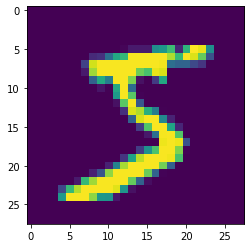

In [3]:
plt.imshow(train_imgs[0, :, :])
plt.show()

# Initialize Function

In [4]:
def get_matrix_from_file(fileName):
    offset = len(ending) + 4
    if fileName[-4-offset] == 'X':
        n_src = n_input                
    else:
        if fileName[-3-offset]=='e':
            n_src = n_e
        else:
            n_src = n_i
    if fileName[-1-offset]=='e':
        n_tgt = n_e
    else:
        n_tgt = n_i
    readout = np.load(fileName)
    print (readout.shape, fileName)
    value_arr = np.zeros((n_src, n_tgt))
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

# Config the parameters and equations

In [110]:
start_scope()

training_mode = True
if training_mode == True:
    data = train_imgs
    label = train_labels
    num_examples = 60000
else:
    data = test_imgs
    label = test_labels
    num_examples = 10000

n_input = 28*28        #eight channels EMG
n_e = 400
n_i = n_e

Ee = 0 * mV
El = -74 * mV
tau_e = 10 * ms
tau_i = 10 * ms

v_rest_e = -65. * mV 
v_rest_i = -60. * mV 
v_reset_e = -60. * mV
v_reset_i = -45. * mV
v_thresh_e = -54. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms

delay_ee = (0*ms,10*ms)
delay_ei = (0*ms, 5*ms)

ending = ''

taupre = taupost = 20*ms
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

init_w_AeAi = 0.5 #10.4
init_w_AiAe = 0.7 #17.

#***********************************************
#                   Equation
#***********************************************
neuron_eqs_e = '''
        dv/dt = (ge * (Ee-v) + El - v) / tau_e : volt (unless refractory)
        dge/dt = -ge / (1.0*ms) : 1
'''

neuron_eqs_i = '''
        dv/dt = (ge * (Ee-v) + El - v) / tau_i : volt (unless refractory)
        dge/dt = -ge / (1.0*ms) : 1
'''

stdp_ee = '''
        w : 1
        dApre/dt = -Apre / taupre : 1 (event-driven)
        dApost/dt = -Apost / taupost : 1 (event-driven)
'''
stdp_ee_pre = '''
        ge += w
        Apre += dApre
        w = clip(w + Apost, 0, gmax)
'''
stdp_ee_post = '''
        Apost += dApost
        w = clip(w + Apre, 0, gmax)
'''

# Network Architecture

In [127]:
# initial input neuron and determine 'rates' as a variable
Xe = NeuronGroup(n_input, 'rates : Hz', threshold='rand()<rates*dt')
Xe.rates = 100*Hz

# initial next layer
Ae = NeuronGroup(n_e, model=neuron_eqs_e, threshold='v > v_thresh_e', reset='v = v_reset_e', refractory=refrac_e, method='euler')
Ai = NeuronGroup(n_i, model=neuron_eqs_i, threshold='v > v_thresh_i', reset='v = v_reset_i', refractory=refrac_i, method='euler')

# input weight
weight_XeAe = get_matrix_from_file('random/' + 'XeAe' + ending + '.npy')
# input to excitatory with all-to-all connection
if training_mode == True:
    S_XeAe = Synapses(Xe, Ae, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
    S_XeAe.connect()
    S_XeAe.w = np.random.rand(len(S_XeAe.w))* gmax
else:
    S_XeAe = Synapses(Xe, Ae, 'w : 1')
    S_XeAe.connect()
    S_XeAe.w = weight_XeAe.flatten()

# excitatory to inhibitory with one-to-one connection
S_AeAi = Synapses(Ae, Ai, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
S_AeAi.connect(j='i')
S_AeAi.w = np.random.rand(len(S_AeAi.w))* gmax
# inhibitory to excitatory with all-to-all except the post-neuron that has the same index
S_AiAe = Synapses(Ai, Ae, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
S_AiAe.connect(condition='i!=j')
S_AiAe.w = np.random.rand(len(S_AiAe.w))* gmax

# monitor  
spike_Xe = SpikeMonitor(Xe)
spike_Ae = SpikeMonitor(Ae)
state_Ae = StateMonitor(Ae, 'v', record=True)
state_XeAe = StateMonitor(S_XeAe, 'w', record=[0])

store()
# run(350*ms, report='text')

# subplot(411)
# plot(S_XeAe.w / gmax, '.k')
# xlabel('Time (ms)')
# ylabel('#Spikes')
# xlim(0, 100)
# subplot(412)
# plot(spike_Ae.t/ms, spike_Ae.i, '.k')
# xlabel('Time (ms)')
# ylabel('#Spikes')
# subplot(413)
# plot(state_Ae.t/ms, state_Ae.v[0])
# xlabel('Time (ms)')
# ylabel('V')
# ylim(-0.070, -0.050)
# subplot(414)
# plot(state_XeAe.t/ms, state_XeAe.w[0])
# xlabel('Time (ms)')
# ylabel('W')



(313600, 3) random/XeAe.npy


In [113]:
print (S_XeAe.w)

<synapses.w: array([0.00210027, 0.00099892, 0.00771045, ..., 0.00690627, 0.00366817,
       0.00353097])>


# Main

In [107]:
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 10
    num_assignments = [0] * 10
    for i in range(10):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
    return np.argsort(summed_rates)[::-1]

def get_new_assignments(result_monitor, input_numbers):
    assignments = np.zeros(n_e)
    input_nums = np.asarray(input_numbers)
    maximum_rate = [0] * n_e    
    for j in range(10):
        num_assignments = len(np.where(input_nums == j)[0])
        if num_assignments > 0:
            rate = np.sum(result_monitor[input_nums == j], axis = 0) / num_assignments
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments

In [ ]:
idx = 0
input_intensity = 2.
start_input_intensity = 2.
update_interval = 10000
resting_time = 150 * ms

previous_spike_count = np.zeros(n_e)
result_monitor = np.zeros((update_interval, n_e))
assignments = np.zeros(n_e)
outputNumbers = np.zeros((num_examples, 10))

    
while idx < len(data):
    restore()
    rates = data[idx, :, :].reshape((n_input)) / 8. * input_intensity
    Xe.rates = rates * Hz
    run(350*ms, report='text')
    
    # update the assignment
    if (idx % 10000) == 0 and idx > 0:
        assignments = get_new_assignments(result_monitor[:], label[idx - update_interval: idx])
    
    current_spike_count = np.asarray(spike_Ae.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_Ae.count[:])
    
    if np.sum(current_spike_count) < 5:
        input_intensity += 2
        Xe.rates = 0 * Hz
        run(resting_time)
    else:
        result_monitor[idx%update_interval, :] = current_spike_count
        print (current_spike_count)
        print (S_XeAe.w)

        outputNumbers[idx,:] = get_recognized_number_ranking(assignments, result_monitor[idx%update_interval,:])
        input_intensity = start_input_intensity
        
        Xe.rates = 0 * Hz
        run(resting_time)
        idx += 1
        
    if (idx == 11):
        break

Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duratio

Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duration of 0.35 s
0.35 s (100%) simulated in < 1s
Starting simulation at t=0. s for a duratio

[0. 9. 8. 7. 6. 5. 4. 3. 2. 1.]


<function matplotlib.pyplot.show(close=None, block=None)>

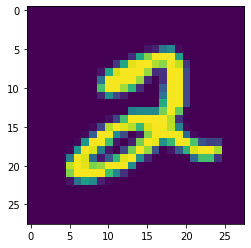

In [122]:
label = 5
print (outputNumbers[label])
plt.imshow(train_imgs[label, :, :])
plt.show


Text(0, 0.5, 'V')

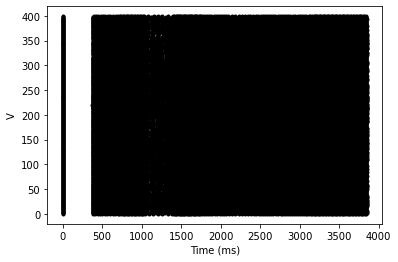

In [10]:
plot(spike_Ae.t/ms, spike_Ae.i, '.k')
xlabel('Time (ms)')
ylabel('V')

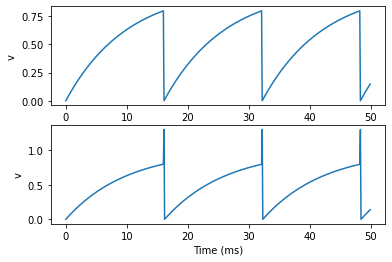

In [92]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs, threshold='v>1.2', reset='v= 0', method='exact')

S = Synapses(G, G2, on_pre='v+=0.5')
S.connect()

M = StateMonitor(G, 'v', record=0)
M2 = StateMonitor(G2, 'v', record=0)
run(50*ms)
subplot(211)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');
subplot(212)
plot(M2.t/ms, M2.v[0])
xlabel('Time (ms)')
ylabel('v');
